In [41]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder, model_cfg_attr='downstream_model_cfg'):
    """
    Load the SSMFoundationalDecoder model from a checkpoint artifact.
    """
    api = wandb.Api()
    artifact = api.artifact(artifact_full_name, type="checkpoint")
    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg[model_cfg_attr])
    print(type(run_cfg))
    model = model_class(
        **model_cfg,
    )
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        
        # Find the checkpoint file in the downloaded directory
        checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
        if not checkpoint_files:
            print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
            raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")
        
        checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
        print(f"Loading checkpoint from: {checkpoint_path}")
        
        with open(checkpoint_path, 'rb') as f:
            meta = json.loads(f.readline().decode())
            trained_model = eqx.tree_deserialise_leaves(f, model)

    return model, trained_model

def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta

In [67]:
discretized_parameters = {'fresh': {}, 'trained': {}}
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/dropskip_rtt_trial_full_l1_d128_checkpoint:best'
model, trained_model = load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder)
models = {
    'fresh': model, 
    'trained': trained_model
}

<class 'omegaconf.dictconfig.DictConfig'>


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpll3sp73r/tmp7kcmzsg5.ckpt


NameError: name 'B' is not defined

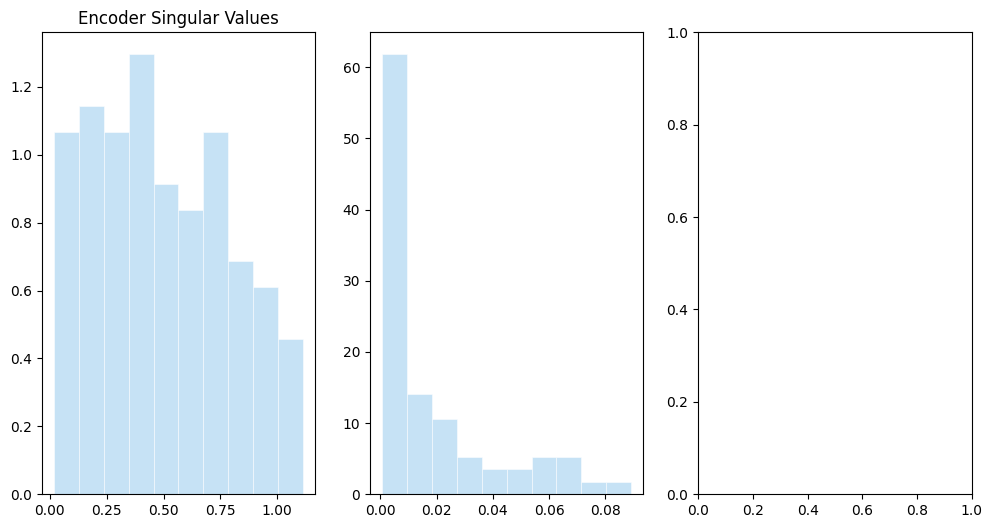

In [90]:
fig, axs = plt.subplots(1, 1 + 2 * len(model.ssm_blocks), figsize=(12, 6))
axs = axs.flatten()

# Color scheme: light colors for "fresh" (before), dark colors for "trained" (after)
colors = {
    'fresh': '#AED6F1',    # Light blue (before)
    'trained': '#1F4E79'   # Dark blue (after)
}

for train_status, m in models.items():
    color = colors[train_status]
    
    # Plot singular values of encoder 
    encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
    axs[0].hist(np.abs(encoder_sv), alpha=0.7, label=f'{train_status} | Encoder', 
                density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[0].set_title('Encoder Singular Values')

    for i, layer in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
        
        # Plot singular values of B 
        b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
        axs[1 + i*2].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status} | Layer {i} B_bar', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[1 + i*2].set_title(f'Layer {i} $\bar{B}$ Singular Values')
        
        # Plot singular values of Lambda_bar
        axs[2 + i*2].hist(np.abs(Lambda_bar), alpha=0.7, label=f'{train_status} | Layer {i} Lambda_bar', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[2 + i*2].set_title(f'Layer {i} Lambda_bar Singular Values')

for ax in axs:
    ax.set_xlabel('Singular Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

In [88]:
m.encoder.weight

Array([[-2.80907359e-02,  1.79849137e-02,  6.57062307e-02, ...,
        -4.99438196e-02, -4.18292694e-02,  1.00693256e-01],
       [-3.65692116e-02,  9.54124425e-03,  7.51389749e-03, ...,
         1.54599464e-02, -1.05392359e-01,  8.03314522e-02],
       [-1.77519862e-04, -6.20235540e-02, -5.90661401e-03, ...,
        -3.83225083e-02, -1.24157248e-02, -2.51691163e-01],
       ...,
       [-9.61622372e-02, -1.59990400e-01, -2.66294867e-01, ...,
         1.10729814e-01,  6.71853647e-02,  4.59141135e-01],
       [-7.68970922e-02,  1.52755305e-02,  1.16502076e-01, ...,
        -1.23799510e-01,  4.17465158e-02,  5.28199434e-01],
       [-6.29460160e-03, -5.41388094e-02, -1.79245874e-01, ...,
         3.35818082e-02,  4.89217341e-02, -2.42504761e-01]],      dtype=float32)

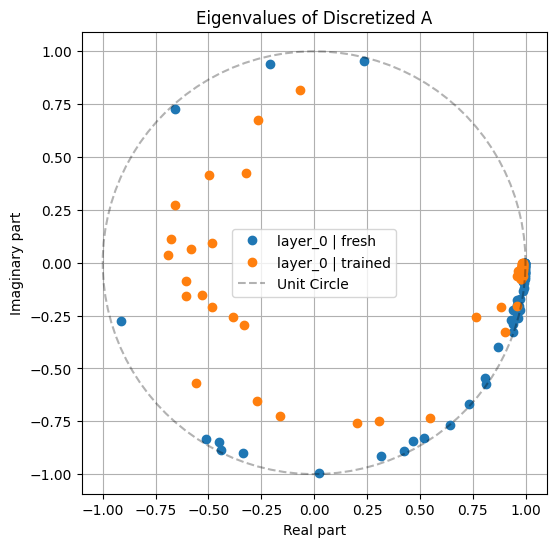

In [77]:
fig = plt.figure(figsize=(6, 6))

for i, (train_status, layers) in enumerate(discretized_parameters.items()):
    for layer_name, params in layers.items():
        Lambda_bar = params['Lambda_bar']
        plt.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=f'{layer_name} | {train_status}')
        # B_bar_sv = params['B_bar_sv']
        # ax.hist(np.abs(Lambda_bar), bins=100, alpha=0.5, label=f'{layer_name} | Lambda_bar')
        # ax.hist(B_bar_sv, bins=100, alpha=0.5, label=f'{layer_name} | B_bar_sv')

# draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
plt.title('Eigenvalues of Discretized A')
plt.axis('equal')
plt.grid()


plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()

In [ ]:
discretized_parameters[f'layer_{i}']['Lambda_bar']

TypeError: tuple indices must be integers or slices, not str